# Primeiro Trabalho - Random Walk

- [0. Introdução](#0.-Introdução)
    - [0.1. Random Walk](#0.1.-Random-Walk)
    - [0.2. Descrição da Tarefa](#0.2.-Descrição-da-Tarefa)
    - [0.3. Bibliotecas utilizadas](#0.3.-Bibliotecas-utilizadas)
- [1. Primeiro caso de teste](#1.-Primeiro-caso-de-teste)
    - [1.1. Implementação](#1.1.-Implementação)
    - [1.2. Execução](#1.2.-Execução)
    - [1.3. Resultados](#1.3.-Resultados)
        - [1.3.1. Tabela](#1.3.1.-Tabela)
        - [1.3.2. Gráfico de Convergência](#1.3.2.-Gráfico-de-Convergência)
- [2. Segundo caso de teste](#2.-Segundo-caso-de-teste)
    - [2.1. Implementação](#2.1.-Implementação)
    - [2.2. Execução](#2.2.-Execução)
    - [2.3. Resultados](#2.3.-Resultados)
        - [2.3.1. Tabela](#2.3.1.-Tabela)
        - [2.3.2. Gráfico de Convergência](#2.3.2.-Gráfico-de-Convergência)

# 0. Introdução

## 0.1. Random Walk

## 0.2. Descrição da Tarefa

## 0.3. Bibliotecas utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Primeiro caso de teste

### 1.1. Implementação

In [2]:
class RandomWalk:
    def __init__(self, n_samples, bounds, function, cutoff, n_gen):
        self.n_samples = n_samples # number of samples in population
        self.bounds = bounds       # dict of bounds for each variable
        self.function = function   # objective function
        self.cutoff = cutoff       # proportion of surviving samples (0,1)
        self.n_gen = n_gen         # number of generations
        self.population = pd.DataFrame(columns=[f"x{i}" for i in range(len(self.bounds))])
        self.stats = pd.DataFrame(columns=["mean", "std"])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)

    # generate or complement population of viable solutions
    def populate(self, n_samples):
        for s in range(n_samples):
            sample = {}
            # each sample is identified by xi and contains len(bounds) values taken from an uniform distribution [0,1)
            r = np.random.uniform(0,1,len(self.bounds))
            sample = {f"x{i}": r[i] for i in range(len(self.bounds))}
            
            # normalize samples to fit the specified bounds
            for i in range(len(sample)):
                sample[f"x{i}"] = self.bounds[i]["lb"] + (self.bounds[i]["ub"] - self.bounds[i]["lb"]) * sample[f"x{i}"]
            
            # append to population and get value of function for each sample
            self.population = self.population.append(sample, ignore_index=True)
        
        # calculate objective function for each function 
        self.population['y'] = self.function(*[self.population[f'{col}'] for col in self.population.columns if col != 'y'])
    
    # define surviving population
    def select(self):
        # sort population by value of function
        self.population.sort_values(by=['y'], ignore_index=True, inplace=True)
        
        # select survivors based on cutoff proportion
        self.population.drop(self.population[self.population.index >= len(self.population)*self.cutoff].index, inplace=True)
        
        self.population.reset_index(drop=True, inplace=True)
        
    # populate, select and extract stats through a given number of rounds
    def execute(self, n_exec):
        best_y = pd.DataFrame(columns=[f"gen_{i}" for i in range(self.n_gen+1)])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)
        
        for e in range(n_exec):
            # generate initial population and select its best samples
            self.population = self.population.iloc[0:0]
            self.populate(self.n_samples)
            self.select()
            
            # dict to store best samples by generation
            best_in_gen = {}
            
            for g in range(self.n_gen+1):
                # repopulate and select best samples
                self.populate(self.n_samples - len(self.population))
                self.select()
                
                # extract best objective function in generation
                best_in_gen[f"gen_{g}"] = self.population['y'].iloc[0]
            
            # append best solutions by execution
            best_y = best_y.append(best_in_gen, ignore_index=True)
            
            # extract best sample by execution
            self.best_solutions = self.best_solutions.append(self.population.iloc[0], ignore_index=True)
        
        # extract mean and std dev by generation
        self.stats = best_y.describe().loc[['mean','std']].T
    
    def get_best_solutions(self):
        return self.best_solutions
    
    def plot_convergence(self):
        sns.set_style("dark")
        plt.figure(figsize=(30,10))
        plt.grid()
        plt.plot(self.stats.index, self.stats["mean"], label="Mean")
        plt.fill_between(range(len(self.stats)), self.stats["mean"]-self.stats["std"], self.stats["mean"]+self.stats["std"], alpha = 0.5, label="Std. Dev.")
        plt.plot(self.stats.index, [min(self.stats["mean"]) for i in range(len(self.stats.index))], label="Minimum")
        plt.xticks(np.arange(0, self.n_gen+1, self.n_gen/10))
        plt.xlabel("Generation")
        plt.ylabel("Fitness values")
        plt.title("Fitness by Generation")
        plt.legend()
        plt.savefig("case1.png", dpi=300)
        plt.show()

### 1.2. Execução

In [3]:
bounds = [{"lb": -3, "ub": 3},
          {"lb": -2, "ub": 4},
          {"lb": 0, "ub": 6}]

lambda_f = lambda x0, x1, x2: 10*(x0-1)**2 + 20*(x1-2)**2 + 30*(x2-3)**2

rw = RandomWalk(100, bounds, lambda_f, .9, 10000)
rw.execute(5)

### 1.3. Resultados

#### 1.3.1. Tabela

In [4]:
rw.get_best_solutions()

,x0,x1,x2,y
0,1.051272,2.032091,3.007355,0.048508
1,0.961669,1.963361,2.985544,0.047809
2,1.155116,2.037665,2.982825,0.277833
3,0.998215,2.056121,2.966858,0.095973
4,0.861771,1.955221,2.999768,0.231178


#### 1.3.2. Gráfico de Convergência

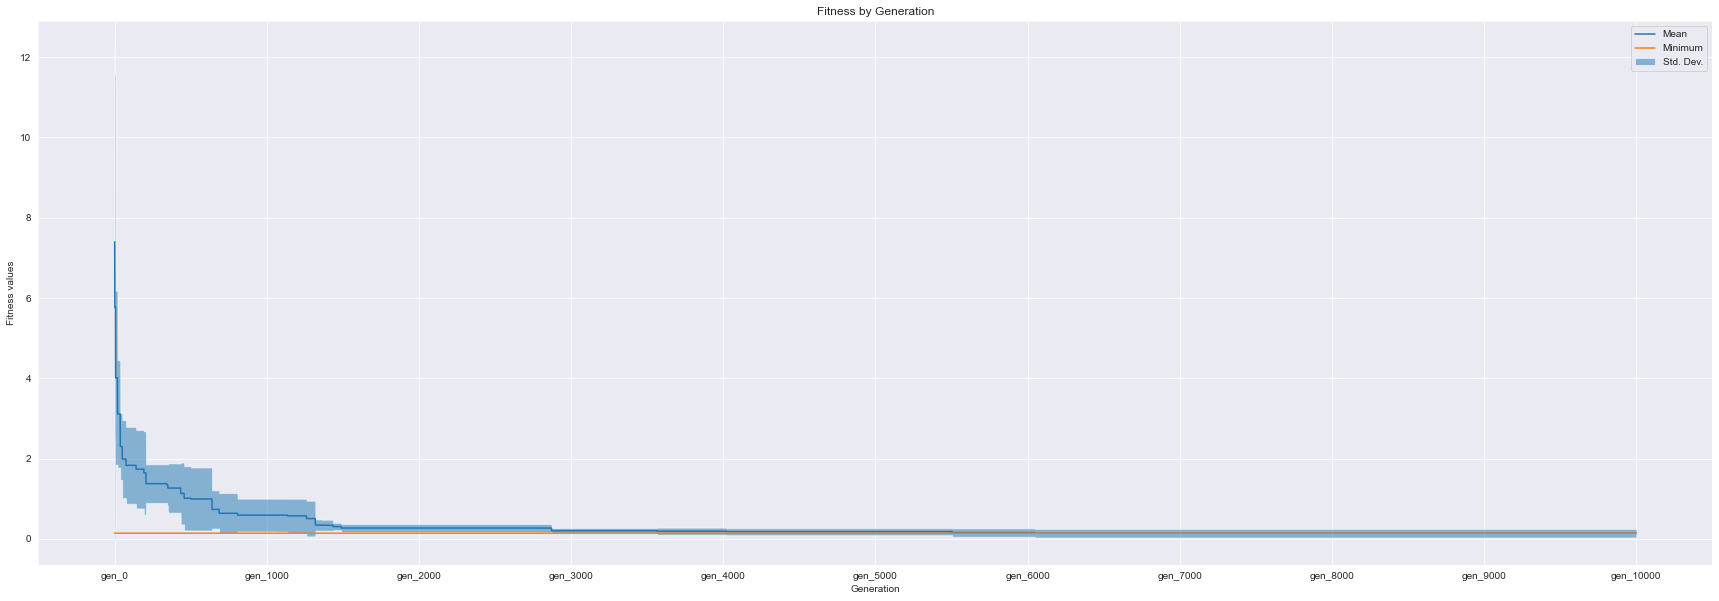

In [5]:
rw.plot_convergence()

## 2. Segundo caso de teste

### 2.1. Implementação

In [13]:
class RandomWalk:
    def __init__(self, n_samples, target, bounds, function, cutoff, n_gen):
        self.n_samples = n_samples # number of samples in population
        self.target = target       # list that represents target
        self.bounds = bounds       # dict of bounds
        self.function = function   # objective function
        self.cutoff = cutoff       # proportion of surviving samples (0,1)
        self.n_gen = n_gen         # number of generations
        self.population = pd.DataFrame(columns=[f"t{i}" for i in range(len(self.target))])
        self.stats = pd.DataFrame(columns=["mean", "std"])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)

    # generate or complement population of viable solutions
    def populate(self, n_samples):
        for s in range(n_samples):
            sample = {}
            # each sample contains len(target) variables taken from an uniform distribution [0,1)
            r = np.random.uniform(0,1,len(self.target))
            sample = {f"t{i}": r[i] for i in range(len(self.target))}
            
            # normalize samples to fit the specified bounds
            for i in range(len(sample)):
                sample[f"t{i}"] = self.bounds["lb"] + (self.bounds["ub"] - self.bounds["lb"]) * sample[f"t{i}"]
            
            # append to population
            self.population = self.population.append(sample, ignore_index=True)
        
        # calculate objective function for each function 
        self.population['y'] = self.function([self.population[f"{col}"] for col in self.population.columns if col != 'y'])
    
    # define surviving population
    def select(self):
        # sort population by value of function
        self.population.sort_values(by=['y'], ignore_index=True, inplace=True)
        
        # select survivors based on cutoff proportion
        self.population.drop(self.population[self.population.index >= len(self.population)*self.cutoff].index, inplace=True)
        
        self.population.reset_index(drop=True, inplace=True)
        
    # populate, select and extract stats through a given number of rounds
    def execute(self, n_exec):
        best_y = pd.DataFrame(columns=[f"gen_{i}" for i in range(self.n_gen+1)])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)
        
        for e in range(n_exec):
            # generate initial population and select its best samples
            self.population = self.population.iloc[0:0]
            self.populate(self.n_samples)
            self.select()
            
            # dict to store best samples by generation
            best_in_gen = {}
            
            for g in range(self.n_gen+1):
                # repopulate and select best samples
                self.populate(self.n_samples - len(self.population))
                self.select()
                
                # extract best objective function in generation
                best_in_gen[f"gen_{g}"] = self.population['y'].iloc[0]
            
            # append best solutions by execution
            best_y = best_y.append(best_in_gen, ignore_index=True)
            
            # extract best sample by execution
            self.best_solutions = self.best_solutions.append(self.population.iloc[0], ignore_index=True)
        
        # extract mean and std dev by generation
        self.stats = best_y.describe().loc[['mean','std']].T
    
    def get_best_solutions(self):
        return self.best_solutions
    
    def plot_convergence(self):
        sns.set_style("dark")
        plt.figure(figsize=(30,10))
        plt.grid()
        plt.plot(self.stats.index, self.stats["mean"], label="Mean")
        plt.fill_between(range(len(self.stats)), self.stats["mean"]-self.stats["std"], self.stats["mean"]+self.stats["std"], alpha = 0.5, label="Std. Dev.")
        plt.plot(self.stats.index, [min(self.stats["mean"]) for i in range(len(self.stats.index))], label="Minimum")
        plt.xticks(np.arange(0, self.n_gen+1, self.n_gen/10))
        plt.xlabel("Generation")
        plt.ylabel("Fitness values")
        plt.title("Fitness by Generation")
        plt.legend()
        plt.savefig("case2.png", dpi=300)
        plt.show()

### 2.2. Execução

In [36]:
target = [52.547, 72.154, 53.694, 57.771, 115.88, 105.59, 75.368, 126.02,
          52.756, 85.100, 80.525, 111.24, 113.62, 64.95, 89.181, 85.647,
          101.71, 106.75, 110.37, 72.082, 104.38, 102.41, 63.009, 59.52,
          89.869, 126.78, 77.231, 96.821, 67.905, 110.1]

lambda_f = lambda word: (sum([(target[i] - word[i])**2 for i in range(len(target))]))**.5

bounds = {"lb": min(target), "ub": max(target)}

rw = RandomWalk(100, target, bounds, lambda_f, .9, 10000)
rw.execute(5)

### 2.3. Resultados

#### 2.3.1. Tabela

In [37]:
display(rw.get_best_solutions())

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t21,t22,t23,t24,t25,t26,t27,t28,t29,y
0,54.876072,67.283584,74.049150,66.736188,96.131632,78.954444,94.938770,113.767759,54.806092,85.286249,...,120.837841,69.979774,77.032065,86.963179,119.971659,123.594117,92.232136,94.514704,90.625527,88.788016
1,59.886711,123.872267,52.863813,60.106003,106.222188,85.732152,74.169515,114.862380,73.299627,69.498493,...,90.929315,66.270819,65.002421,83.446812,101.528080,95.205162,66.073405,85.856140,118.796430,95.119799
2,66.379020,67.132848,54.486809,68.144128,100.116411,111.906263,95.781197,115.692830,53.263704,98.596644,...,106.915336,55.304079,60.388272,75.508997,120.559078,66.664333,86.147909,81.629904,114.248141,91.623451
3,68.184826,95.919430,54.736062,57.142251,108.252784,124.782853,97.464055,113.476223,60.530119,90.275562,...,111.833281,71.154790,71.337341,90.670426,88.419688,110.187497,80.818729,56.092440,98.884144,94.544412
4,61.021242,67.902943,69.342054,79.428085,86.809385,96.608622,107.209106,118.047906,54.496092,94.612559,...,74.147949,91.238281,72.518102,85.411539,117.867213,70.947778,87.003808,72.651634,121.777442,96.751393


#### 2.3.2. Gráfico de Convergência

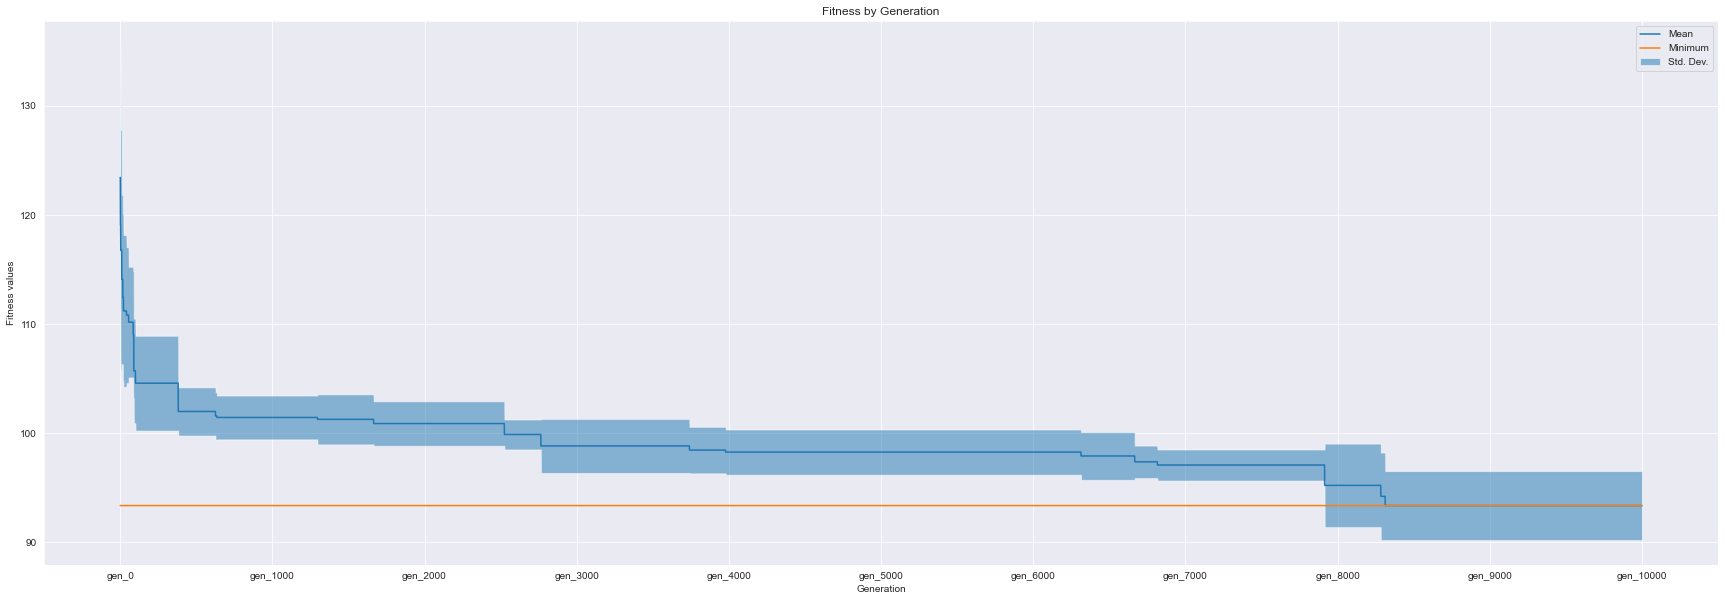

In [38]:
rw.plot_convergence()